In [47]:
import numpy as np
import sympy as sp
from scipy.special import roots_legendre
import scipy.linalg as la
import matplotlib.pyplot as plt
from FEM import *
from tools import 
from shape_functions import *
# plt.style.use('default')
import copy


In [48]:

class phi_func_l(shape_function):
    def __init__(self, scale, p):
        super().__init__(scale)
        self.p = p
        self.range = [0, 1]
    def expression(self, x):
        if self.p == 0:
            phi = 1-self.mapping(x)
        elif self.p == 1:
            phi = self.mapping(x) 
        else:
            raise AssertionError("p should be 0 or 1 in linear shape function, not{}".format(self.p))
        return phi
        
class phip_func_l(shape_function):
    def __init__(self, scale, p):
        super().__init__(scale)
        self.range = [0, 1]
        self.p = p
    def expression(self, x):
        scale_up = 1/(self.scale[1]-self.scale[0]) 
        
        if self.p == 0:
            phip =  np.zeros_like(self.mapping(x))-1
        elif self.p == 1:
            phip = np.zeros_like(self.mapping(x))+1
        else:
            raise AssertionError("p should be 0 or 1 in linear shape function, not{}".format(self.p))
        return phip*scale_up
    
class phi_func_q(shape_function):
    def __init__(self, scale, p):
        super().__init__(scale)
        self.range = [0, 1]
        self.p = p
    def expression(self, x):
        xx = self.mapping(x)
        if self.p == -1:
            phi = (xx-1)*(xx-0.5)*2
        elif self.p == 0:
            phi = -xx*(xx-1)*4
        elif self.p ==1:
            phi = xx*(xx-0.5)*2
        else:
            raise AssertionError("p should be -1, 0 or 1 in quadratic shape function, not{}".format(self.p))
        return phi
        
class phip_func_q(shape_function):
    def __init__(self, scale, p):
        super().__init__(scale)
        self.range = [0, 1]
        self.p = p
    def expression(self, x):
        scale_up = 1/(self.scale[1]-self.scale[0]) 
        xx = self.mapping(x)
        if self.p == -1:
            phip = 4*xx - 3.0
        elif self.p == 0:
            phip = 4-8*xx
        elif self.p ==1:
            phip = 4*xx - 1.0
        else:
            raise AssertionError("p should be -1, 0 or 1 in quadratic shape function, not{}".format(self.p))
        return phip*scale_up
    
class phi_func_h(shape_function):
    def __init__(self, scale, p):
        super().__init__(scale)
        self.p = p
    def expression(self, x):
        scale = self.scale
        i =self.p
        if i == 0:
            phi = (1-self.mapping(x))/2 
        elif i == 1:
            phi = (1+self.mapping(x))/2 
        else:
            phi = 1/np.sqrt(4*i-2)*(Legendre(self.mapping(x), i)-Legendre(self.mapping(x), i-2))
        return phi
        
class phip_func_h(shape_function):
    def __init__(self, scale, p):
        super().__init__(scale)
        self.p = p
    def expression(self, x):
        scale_up = 2/(self.scale[1]-self.scale[0]) 
        i =self.p
        
        if i == 0:
            phip =  np.zeros_like(self.mapping(x))-0.5
        elif i == 1:
            phip = np.zeros_like(self.mapping(x))+0.5
        else:
            phip = np.sqrt(i-1/2)*(Legendre(self.mapping(x), i-1))
        return phip*scale_up
    
def Hierarchical(scale, p):
    phis = []
    phips = []
    start=0
    
    for i in range(start, p+1):
        new_phi = phi_func_h(scale, i)
        new_phip = phip_func_h(scale,i)
        phis.append(new_phi)
        phips.append(new_phip)
    return phis, phips

def linear(scale, p):
    phis = []
    phips = []
    p = 1
    for i in range(p+1):
        new_phi = phi_func_l(scale, i)
        new_phip = phip_func_l(scale,i)
        phis.append(new_phi)
        phips.append(new_phip)
    return phis, phips

def quadratic(scale, p):
    phis = []
    phips = []
    p = 1
    for i in range(-1, p+1):
        new_phi = phi_func_q(scale, i)
        new_phip = phip_func_q(scale,i)
        phis.append(new_phi)
        phips.append(new_phip)
    return phis, phips

In [49]:
def joint_funcs(functions):
    if type(functions) != list:
        raise AssertionError("Inputs must be a list!")
    elif not callable(functions[0]):
        raise AssertionError("Elements in the list must be functions!")
    if len(functions)%3==0:
        chunk_size = 3
    elif len(functions)%2==0:
        chunk_size = 2
    spilt_list = [functions[i:i+chunk_size] for i in range(0, len(functions), chunk_size)]
    new_lst = spilt_list[0]
    for lst in spilt_list[1:]:
        new_lst[-1] = plus(new_lst[-1], lst[0])
        new_lst+=lst[1:]

    return new_lst

In [50]:
domain = (0, 1)
N = 6
num_elems = 2
BCs = (0, 0)

p = 3
def h_FEM(shape_class = linear, num_elems = 3,p=3, domain = (0, 1),rhs_func = rhs_fn(a=50, xb=0.8), exact_func=exact_fn(0.5,0.8), BCs = (0, 0), verbose = False):
    mesh = np.linspace(domain[0], domain[1], num_elems+1)
    ori_phi_phip = {'phis': [], 'phips': []}
    for elem in range(num_elems):
        scale = [mesh[elem], mesh[elem+1]]
        phis, phips = shape_class(scale, p)
        ori_phi_phip['phis'].append(phis)
        ori_phi_phip['phips'].append(phips)


    linear_phi_phip = {'phis': [], 'phips': []}  # Linear
    for elem in range(num_elems):
        linear_phis = []
        linear_phips = []
        for idx in range(len(ori_phi_phip['phis'][elem])):
            phi = ori_phi_phip['phis'][elem][idx]
            phip = ori_phi_phip['phips'][elem][idx]
            linear_phi_phip['phis'].append(phi)
            linear_phi_phip['phips'].append(phip)
            linear_phis.append(phi)
            linear_phips.append(phip)
        linear_K_sub = np.zeros((len(linear_phips), len(linear_phips)))
        for indx, x in np.ndenumerate(linear_K_sub):
            linear_K_sub[indx] = G_integrate(
                mul(linear_phips[indx[0]], linear_phips[indx[-1]]), N=6, scale=linear_phips[indx[0]].scale)
            if abs(linear_K_sub[indx]) < 1e-10:
                linear_K_sub[indx] = 0
        # print('K_sub', linear_K_sub)
        linear_F_sub = np.zeros(len(linear_K_sub))
        for indx in range(len(linear_F_sub)):
            linear_F_sub[indx] = G_integrate(
                mul(rhs_func, linear_phis[indx]), N=N, scale=linear_phis[indx].scale)
            # print(phis[indx](mesh[i]))
        if elem == 0:
            K = linear_K_sub
            F = linear_F_sub
        else:
            K = assemble(K, linear_K_sub)
            F = assemble(F, linear_F_sub)
            
    # Applying boundary condition
    K[0, 1:] = 0.0 
    K[-1, :-1] = 0.0
    F[0] = BCs[0]* K[0, 0] # -= or = ??
    F[-1] = BCs[-1] * K[-1, -1]

    U = -la.solve(K, F)
    phi_phip = {'phis': [], 'phips': []}
    phi_phip['phis'] = joint_funcs(linear_phi_phip['phis'])
    phi_phip['phips'] = joint_funcs(linear_phi_phip['phips']) 
    u_list = []
    for i in range(len(phi_phip['phis'])):
        u_list.append(mul(U[i], phi_phip['phis'][i]))
    uh = plus(u_list)
    if verbose == True:
        print(f"Shape class: {shape_class.__name__}, Number of elements: {num_elems}, Polynomial order:{p},  Domain: {domain}, Boundary conditions: {BCs}")
        x_data = np.linspace(domain[0], domain[1], 128)
        plt.plot(x_data, exact_func(x_data), label=' Analytical solution')
        plt.plot(x_data, uh(x_data), label='FEM solution {} elements'.format(num_elems))
        for i in range(len(phi_phip['phis'])):
            func = phi_phip['phis'][i]
            plt.plot(x_data, U[i]*func(x_data))
        plt.legend()
        plt.show()
    return U, phi_phip, uh
def cal_energy(U_array, phi_phip_array):
    U_energy = 0
    u_prime_list = []
    scales = []
    for i in range(len(phi_phip_array['phis'])):
        u_prime = mul(U_array[i], phi_phip_array['phips'][i])
        u_prime_list.append(u_prime)
        scales.append(u_prime.scale)
    # 首先，把嵌套的列表变为一个扁平的列表
    flat_scales = [item for sublist in scales for item in sublist]

    # 然后，把所有的值都保留到五位小数
    rounded_scales = [round(num, 5) for num in flat_scales]

    # 现在，用 set 来获取所有的唯一值
    nodes = list(set(rounded_scales))
    mesh = np.linspace(min(nodes), max(nodes), len(nodes))
    # print(mesh)
    for i in range(len(mesh)-1):
        scale = [mesh[i], mesh[i+1]]
        U_energy+=G_integrate(mul(plus(u_prime_list), plus(u_prime_list)),N=6, scale=scale)
    # scale = [min(mesh), max(mesh)]
    # print(scale)
    # U_energy+=G_integrate(mul(plus(u_prime_list), plus(u_prime_list)),N=6, scale=scale)
    return U_energy/2


In [65]:
def p_FEM(shape_class = Hierarchical, p = 3, num_elems = 3, domain = (0, 1),rhs_func = rhs_fn(a=50, xb=0.8), exact_func=exact_fn(0.5,0.8), BCs = (0, 0), verbose = False):
    mesh = np.linspace(domain[0], domain[1], num_elems+1)
    ori_phi_phip = {'phis': [], 'phips': []}
    for elem in range(num_elems):
        scale = [mesh[elem], mesh[elem+1]]
        phis, phips = shape_class(scale, p)
        ori_phi_phip['phis'].append(phis)
        ori_phi_phip['phips'].append(phips)


    linear_phi_phip = {'phis': [], 'phips': []}  # Linear
    for elem in range(num_elems):
        linear_phis = []
        linear_phips = []
        for idx in range(len(ori_phi_phip['phis'][elem])):
            if ori_phi_phip['phis'][elem][idx].p < 2:
                phi = ori_phi_phip['phis'][elem][idx]
                phip = ori_phi_phip['phips'][elem][idx]
                linear_phi_phip['phis'].append(phi)
                linear_phi_phip['phips'].append(phip)
                linear_phis.append(phi)
                linear_phips.append(phip)
        linear_K_sub = np.zeros((len(linear_phips), len(linear_phips)))
        for indx, x in np.ndenumerate(linear_K_sub):
            linear_K_sub[indx] = G_integrate(
                mul(linear_phips[indx[0]], linear_phips[indx[-1]]), N=6, scale=linear_phips[indx[0]].scale)
            if abs(linear_K_sub[indx]) < 1e-10:
                linear_K_sub[indx] = 0
        # print('K_sub', K_sub)
        linear_F_sub = np.zeros(len(linear_K_sub))
        for indx in range(len(linear_F_sub)):
            linear_F_sub[indx] = G_integrate(
                mul(rhs_func, linear_phis[indx]), N=N, scale=linear_phis[indx].scale)
            # print(phis[indx](mesh[i]))
        if elem == 0:
            K = linear_K_sub
            F = linear_F_sub
        else:
            K = assemble(K, linear_K_sub)
            F = assemble(F, linear_F_sub)
            
    # Applying boundary condition
    K[0, 1:] = 0.0 
    K[-1, :-1] = 0.0
    F[0] = BCs[0]* K[0, 0] # -= or = ??
    F[-1] = BCs[-1] * K[-1, -1]

    nonlinear_phi_phip = {'phis': [], 'phips': []}
    for order in range(2, p+1):  # Non Linear
        # print('order', order)
        for elem in range(num_elems):
            for idx in range(len(ori_phi_phip['phis'][elem])):
                if (ori_phi_phip['phis'][elem][idx].p == order) or (ori_phi_phip['phips'][elem][idx].p == order):
                    nonlinear_phi = ori_phi_phip['phis'][elem][idx]
                    nonlinear_phip = ori_phi_phip['phips'][elem][idx]
                    nonlinear_phi_phip['phis'].append(nonlinear_phi)
                    nonlinear_phi_phip['phips'].append(nonlinear_phip)
                    nonlinear_K_sub = np.zeros((2, 2))
                    # print('nonlinear_phip', nonlinear_phip.p)
                    # print(G_integrate(mul(nonlinear_phip, nonlinear_phip),N=N, scale=nonlinear_phip.scale))
                    
                    nonlinear_K_sub[-1, -1] = G_integrate(mul(nonlinear_phip, nonlinear_phip),N=N, scale=nonlinear_phip.scale)
                    nonlinear_F_sub = np.zeros(2)
                    nonlinear_F_sub[-1] = G_integrate(mul(rhs_func, nonlinear_phi), N=N, scale=nonlinear_phi.scale)

                    K = assemble(K, nonlinear_K_sub)
                    F = assemble(F, nonlinear_F_sub)
                else:
                    pass

    U = -la.solve(K, F)
    # print(F)
    phi_phip = {'phis': [], 'phips': []}
    phi_phip['phis'] = joint_funcs(linear_phi_phip['phis']) + nonlinear_phi_phip['phis']
    phi_phip['phips'] = joint_funcs(linear_phi_phip['phips']) + nonlinear_phi_phip['phips']
    u_list = []
    for i in range(len(phi_phip['phis'])):
        u_list.append(mul(U[i], phi_phip['phis'][i]))
    uh = plus(u_list)
    if verbose == True:
        print(f"Shape class: {shape_class.__name__}, Number of elements: {num_elems}, Polynomial order:{p},  Domain: {domain}, Boundary conditions: {BCs}")
        x_data = np.linspace(domain[0], domain[1], 101)
        plt.plot(x_data, exact_func(x_data), label='Analytical solution')
        plt.plot(x_data, uh(x_data), label='FEM solution {} elements'.format(num_elems))
        for i in range(len(phi_phip['phis'])):
            func = phi_phip['phis'][i]
            plt.plot(x_data, U[i]*func(x_data))
        plt.legend()
        plt.show()
    return U, phi_phip, uh


# Linear

In [66]:
num_elems = 4
domain = (0, 1)
mesh = np.linspace(domain[0], domain[1], num_elems+1)
a = .5*1
xb = 0.8
if a == 50:
    U_init = 1.585854059271320
elif a == 0.5:
    U_init = 0.03559183822564316
exact_func = exact_fn(a = a, xb=xb)
rhs_func = rhs_fn(a=a, xb=xb)
BCs = (exact_func(domain[0]), exact_func(domain[-1]))


Shape class: linear, Number of elements: 10, Polynomial order:5,  Domain: (0, 1), Boundary conditions: (0.0, 0.0)


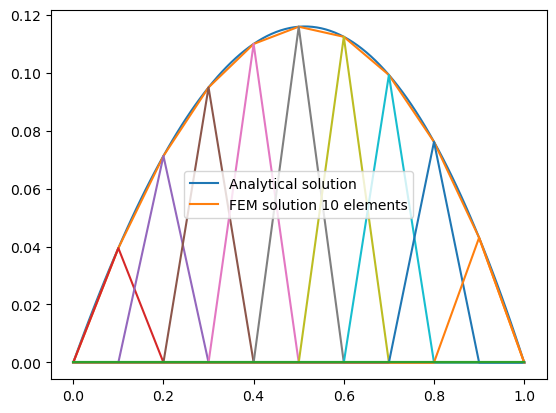

0.03524249095682372

In [70]:
num_elems = 10

U_l_test, phi_phip_l_test, uh_l_test = p_FEM(shape_class = linear,p=p, num_elems = num_elems, domain = domain,rhs_func = rhs_func,exact_func=exact_func, BCs = BCs, verbose = True)
cal_energy(U_l_test, phi_phip_l_test)

# Quadratic

Shape class: quadratic, Number of elements: 10, Polynomial order:5,  Domain: (0, 1), Boundary conditions: (0.0, 0.0)


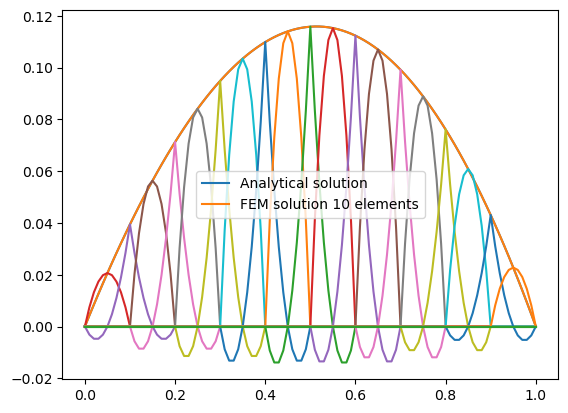

0.03559182991739081

In [69]:
num_elems = 10
U_q_test, phi_phip_q_test, uh_l_test = p_FEM(shape_class = quadratic,p=p, num_elems = num_elems, domain = domain,rhs_func = rhs_func,exact_func=exact_func, BCs = BCs, verbose = True)
cal_energy(U_q_test, phi_phip_q_test)

# P_FEM

Shape class: Hierarchical, Number of elements: 1, Polynomial order:5,  Domain: (0, 1), Boundary conditions: (0.0, 0.0)


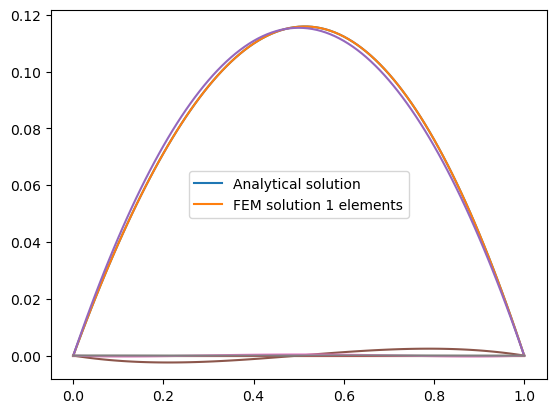

0.03559183805283584

In [62]:
num_elems = 1
p = 5
exact_func = exact_fn(a = a, xb=xb)
rhs_func = rhs_fn(a=a, xb=xb)
BCs = (exact_func(domain[0]), exact_func(domain[-1]))

U_l_test, phi_phip_l_test, uh_l_test = p_FEM(shape_class = Hierarchical,p=p, num_elems = num_elems, domain = domain,rhs_func = rhs_func,exact_func=exact_func, BCs = BCs, verbose = True)
cal_energy(U_l_test, phi_phip_l_test)

# Log-log plot

In [56]:
num_elems_list = [2, 4, 8, 16, 32]
domain = (0, 1)
mesh = np.linspace(domain[0], domain[1], num_elems+1)
a = .5*1
xb = 0.8
if a == 50:
    U_init = 1.585854059271320
elif a == 0.5:
    U_init = 0.03559183822564316
error_list_l = []
DOFs_l = []
error_list_q = []
DOFs_q = []
solution_l = []
solution_q = []
for num_elems in num_elems_list:
    U_l, phi_phip_l, uh_l = h_FEM(shape_class = linear,num_elems = num_elems, domain = domain,rhs_func = rhs_func,exact_func=exact_func, BCs = BCs, verbose = False)
    energy_fem_l = cal_energy(U_l, phi_phip_l)
    error_l = np.sqrt(abs(energy_fem_l-U_init)/U_init)
    DOFs_l.append(len(U_l))
    error_list_l.append(error_l)
    solution_l.append(uh_l)
    
    U_q, phi_phip_q, uh_q = h_FEM(shape_class = quadratic,num_elems = num_elems, domain = domain,rhs_func = rhs_func,exact_func=exact_func, BCs = BCs, verbose = False)
    energy_fem_q = cal_energy(U_q, phi_phip_q)
    error_q = np.sqrt(abs(energy_fem_q-U_init)/U_init)
    DOFs_q.append(len(U_q))
    error_list_q.append(error_q)
    solution_q.append(uh_q)


In [57]:
x_data = np.linspace(domain[0], domain[1], 128)
for idx in range(len(solution_l)):
    mesh_l = np.linspace(domain[0], domain[1], num_elems_list[idx]+1)
    mesh_l = np.linspace(domain[0], domain[1], 128)
    # print(mesh_l)s
    plt.plot(mesh_q, solution_l[idx](mesh_q), label=' {} elements'.format(num_elems_list[idx]))
plt.plot(x_data, exact_func(x_data), label='Exact solution')
plt.legend()

NameError: name 'mesh_q' is not defined

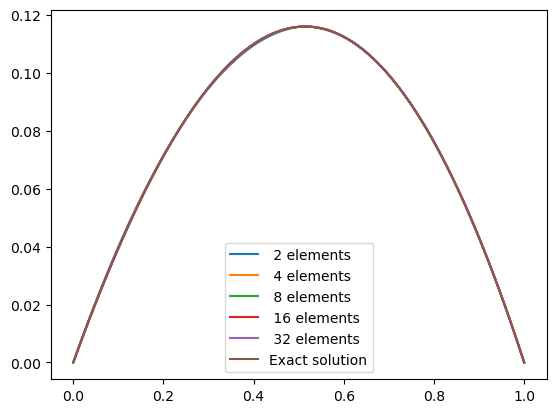

In [60]:
x_data = np.linspace(domain[0], domain[1], 128)
for idx in range(len(solution_q)):
    mesh_q = np.linspace(domain[0], domain[1], num_elems_list[idx]+1)
    mesh_q = np.linspace(domain[0], domain[1], 128)

    plt.plot(mesh_q, solution_q[idx](mesh_q), label=' {} elements'.format(num_elems_list[idx]))
plt.plot(x_data, exact_func(x_data), label='Exact solution')
plt.legend()

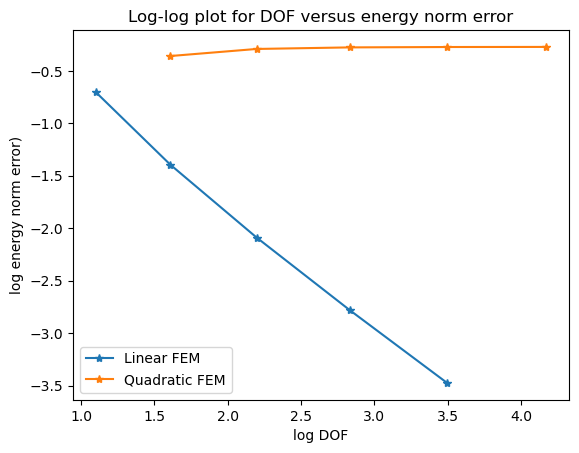

In [ ]:

truncate = 0
plt.plot(np.log(DOFs_l[truncate:]), np.log(error_list_l[truncate:]), '*-', label='Linear FEM')
plt.plot(np.log(DOFs_q[truncate:]), np.log(error_list_q[truncate:]), '*-', label='Quadratic FEM')
plt.xlabel('log DOF')
plt.ylabel('log energy norm error)')
plt.title('Log-log plot for DOF versus energy norm error')
plt.legend()
plt.show()


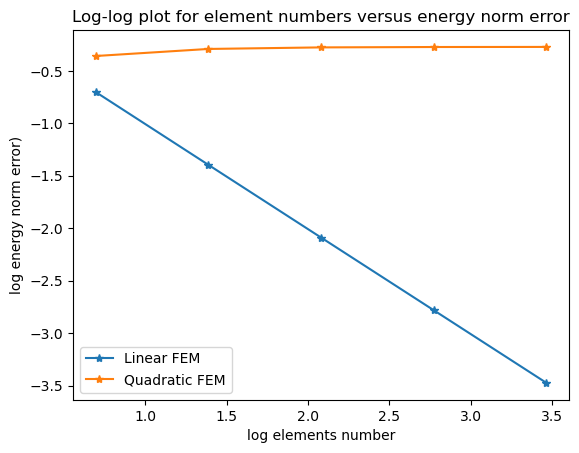

In [ ]:
truncate = 0
plt.plot(np.log(num_elems_list[truncate:]), np.log(error_list_l[truncate:]), '*-', label='Linear FEM')
plt.plot(np.log(num_elems_list[truncate:]), np.log(error_list_q[truncate:]), '*-', label='Quadratic FEM')
plt.xlabel('log elements number')
plt.ylabel('log energy norm error)')
plt.title('Log-log plot for element numbers versus energy norm error')
plt.legend()
plt.show()

# Quadratic 